### Example 2: Changing Radius with a Fixed Wavelength-dependent Refractive Index

This example shows how to calculate BLS spectra for particles with the same wavelength-dependent refractive index across the desired wavelength range for a range of different radii. This example uses a two-term Cauchy expression to calculate the refractive index, but users are free to use whichever distribution they choose&mdash;the code is written such that it will run regardless of which function is chosen. The only requirement is that the resulting refractive index array is the same length as the wavelengths chosen. This example is representative of a situation commonly found in aerosol science, namely a volatile substance slowly evaporating&mdash;and therefore shrinking&mdash;over time.

### Import Necessary Packages

Imports the packages needed to perform calculations. All are standard packages and should be a part of any IDE, aside from BLSfunctions which should be downloaded along with this Notebook and placed in the same folder.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import BLSfunctions as BLS
import time

### Set Parameters for Calculation

Set parameter ranges to be used in calculation. As written, the units for radius and wavelength are in microns. This is not necessary but you should use the same units for both. Details of the experimental geometry can be found in this paper [insert doi] to guide users in how to choose $\theta_i$ and $\varphi_i$ for their desired experimental geometry. 

In [2]:
wl = np.linspace(0.4, 0.8, 1201) #wavelength range and resolution
r = np.linspace(1.0,3.0,21) #radii to use in calculations
theta_i = np.pi/2 #incident light theta
phi_i = np.pi/2 #incident light phi
NA = 0.5 #numerical aperture of collection lens

### Calculate Refractive Index

Use the Cauchy expression with two terms ($n = n_0 + n_1/\lambda^2$) to calculate the wavelength-dependence of the refractive index. Note that there is nothing special about this form: users may add more terms or use entirely different equations to calculate the refractive index. The only requirement is that the length of the resulting array of RI values is the same as the length of the input wavelengths.

In [ ]:
n0 = 1.35 #n0 term for Cauchy expression
n1 = 4e-3 #n1 term for Cauchy expression
m = n0 + n1/(wl**2) #real part of refractive index
plt.plot(wl, m, linewidth=1)
plt.xlabel(r'Wavelength ($\mu$m)')
plt.ylabel(r'Refractive Index')
plt.show()

### Calculate Spectra

Calculates spectra using the parameters set above. Full details of the algorithm, along with the rationale behind the order of various steps, choices of number of angular grid points, and the choice of the trapezoidal rule, can be found in this paper [insert doi]. A brief outline of the steps is as follows:
- Calculate incident wavevector and size parameters from input variables
- Find Wiscombe limit for each size parameter
- Calculate number of grid points to use for each radius (and ensure these are even)
- Calculate prefactors for each value of n needed
- Loop over radius values
    * Calculate scattering coefficients up to Wiscombe limit for each size parameter
    * Calculate scattered wavevectors and angular functions with necessary number of grid points up to Wiscombe limit
    * Loop over wavelengths
        + Calculate $S_1, S_2$ by performing necessary summations 
        + Calculate $S_{11}$ for each angular grid point
        + Integrate $S_{11}$ using the trapezoidal rule to get scattered intensity at chosen wavelength

In [5]:
wn = (2*np.pi)/wl #wavenumber of incident light
vi = np.transpose(np.array([np.sin(theta_i)*np.cos(phi_i), np.sin(theta_i)*np.sin(phi_i), np.cos(theta_i)])) #incident wavevector
x = np.zeros((np.size(r), len(wl))) #space for size parameters
for i0, ri in enumerate(r):
    x[i0,:] = (2*np.pi*ri)/wl #calculate size parameters for each radius
omax = np.round(x + (4*(x**(1/3))) + 2).astype(int) #maximum order to which sums need to be evaluated for each size parameter
o = np.linspace(1, np.max(omax), np.max(omax)) #list of orders used to calculate prefactors, coefficients and angular functions
omaxr = np.max(omax, axis=1) #maximum order required in summation for each radius
npts = np.round((0.75*NA*omaxr)) + 18 #number of pts to use for numerical integration
odd = np.mod(npts, 2) == 1 #find odd grid points
npts[odd] += 1 #make odd grid points even
pf = ((2*o)+1)/(o*(o+1)) #prefactors for eventual sum
spectra = np.zeros_like(x) #space for scattering spectra
for i0 in range(len(r)):
    lstart = time.time()
    an = np.zeros((len(o), len(wl)), dtype=complex)
    bn = np.zeros_like(an) #space for coefficients for given radius
    for i1 in range(omaxr[i0]):
        an[i1,:] = pf[i1]*BLS.Mie_an(int(o[i1]), m, x[i0,:])
        bn[i1,:] = pf[i1]*BLS.Mie_bn(int(o[i1]), m, x[i0,:]) #calculate given order of coefficients multiplied by prefactor
    theta_s = np.linspace(0, np.arcsin(NA), int(npts[i0]))#range of scattered theta to look at (angle between scattered wavevector and detector axis)
    phi_s = np.linspace(0, 2*np.pi, int(npts[i0])) #range of scattered phi to use (angle between scattered wavevector and x-axis)
    theta_c = np.zeros((len(theta_s), len(phi_s)))
    for i1 in range(len(theta_s)):
        for i2 in range(len(phi_s)):
            vs = np.transpose(np.array([np.sin(theta_s[i1])*np.cos(phi_s[i2]), np.sin(theta_s[i1])*np.sin(phi_s[i2]), np.cos(theta_s[i1])])) #scattering vector components (minus k, which is not needed for collection angle calculation)
            theta_c[i1,i2] = np.arccos(np.dot(vi,vs)) #collection angle for scattered wavevector
    pin = np.zeros((len(theta_s), len(phi_s), omaxr[i0]))
    taun = np.zeros_like(pin) #space for values of pi_n and tau_n (independent of size parameter except for summation maximum, so can be evaluated before loop and called on later)
    for i1 in range(len(theta_s)):
        pn = BLS.Mie_pin(omaxr[i0], theta_c[i1,:])
        tn = BLS.Mie_taun(omaxr[i0], theta_c[i1,:]) #calculate necessary range of pi_n and tau_n across collection angle range
        pin[i1,:,:] = np.transpose(pn)
        taun[i1,:,:] = np.transpose(tn) #put into matrices
    spectrum = np.zeros_like(wl) #space for spectrum at given radius
    for i1 in range(len(wl)):
        S1 = complex(0,0)
        S2 = complex(0,0) #initial values for summation
        for i2 in range(omax[i0,i1]):
            S1 += (an[i2,i1]*pin[:,:,i2]) + (bn[i2,i1]*taun[:,:,i2])
            S2 += (an[i2,i1]*taun[:,:,i2]) + (bn[i2,i1]*pin[:,:,i2]) #calculate summation terms
        S11 = (1/(2*(wn[i1]**2)))*((np.abs(S2)**2) + (np.abs(S1)**2)) #calculate S11 as function of theta and phi
        theta_int_terms = np.zeros_like(S11)
        for i2 in range(len(phi_s)):
            theta_int_terms[:,i2] = np.sin(theta_s)*S11[:,i2] #calculate terms for theta integration (multiply S11 terms by sin(theta))
        phi_int_terms = ((theta_s[1] - theta_s[0])/2)*(theta_int_terms[0,:] + theta_int_terms[-1,:] + 2*np.einsum('ij->j',theta_int_terms[1:-1,:])) #perform theta integration using Simpson's 1/3 rule for regular spaced points
        spectrum[i1] = ((phi_s[1] - phi_s[0])/2)*(phi_int_terms[0] + phi_int_terms[-1] + 2*np.einsum('i->', phi_int_terms[1:-1])) #perform phi integration using Simpson's 1/3 rule and put into vector
    spectra[i0,:] = spectrum #put spectrum into matrix
    print("Spectrum", str(i0+1), "of", str(len(r)), "complete in", time.time()-lstart, "s.")

Spectrum 1 of 21 complete in 1.2675466537475586 s.
Spectrum 2 of 21 complete in 0.7804727554321289 s.
Spectrum 3 of 21 complete in 0.8476846218109131 s.
Spectrum 4 of 21 complete in 0.8840641975402832 s.
Spectrum 5 of 21 complete in 0.982954740524292 s.
Spectrum 6 of 21 complete in 1.0003759860992432 s.
Spectrum 7 of 21 complete in 1.149923324584961 s.
Spectrum 8 of 21 complete in 1.1834838390350342 s.
Spectrum 9 of 21 complete in 1.1998836994171143 s.
Spectrum 10 of 21 complete in 1.2165982723236084 s.
Spectrum 11 of 21 complete in 1.3001527786254883 s.
Spectrum 12 of 21 complete in 1.3499805927276611 s.
Spectrum 13 of 21 complete in 1.4363934993743896 s.
Spectrum 14 of 21 complete in 1.518070936203003 s.
Spectrum 15 of 21 complete in 1.4998433589935303 s.
Spectrum 16 of 21 complete in 1.5990502834320068 s.
Spectrum 17 of 21 complete in 1.6818549633026123 s.
Spectrum 18 of 21 complete in 1.6981449127197266 s.
Spectrum 19 of 21 complete in 1.7723283767700195 s.
Spectrum 20 of 21 comple

### Plots

Plots spectra as function of wavelength and radius.

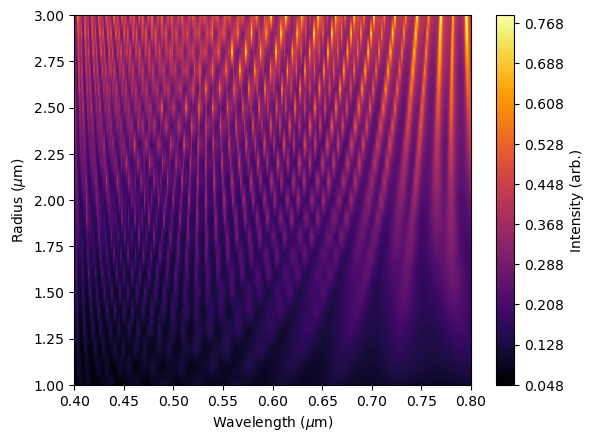

In [6]:
plt.contourf(wl, r, spectra, 100, cmap='inferno')
plt.colorbar(label='Intensity (arb.)')
plt.xlabel(r'Wavelength ($\mu$m)')
plt.ylabel(r'Radius ($\mu$m)')
plt.show()